# CS 178 Project
## Import part

In [22]:
import os
import numpy as np
import pandas as pd
import cv2

from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

## Read image for train

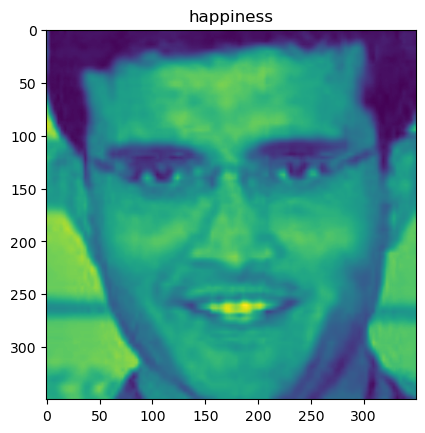

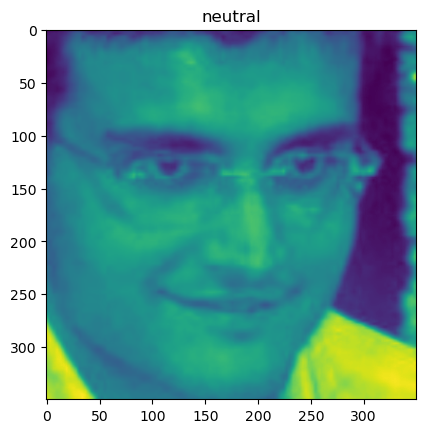

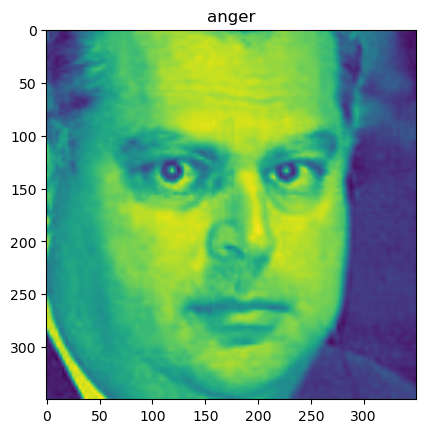

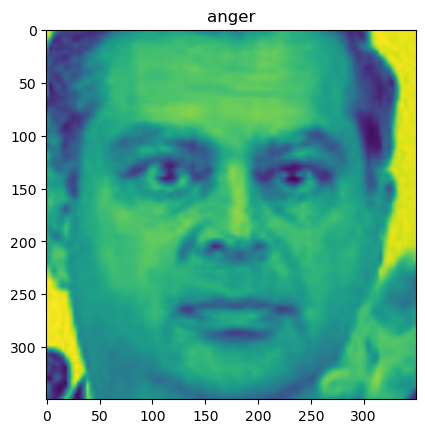

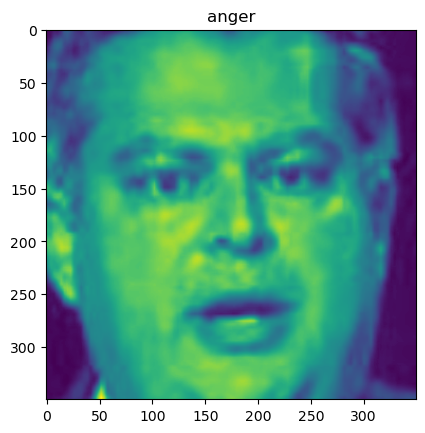

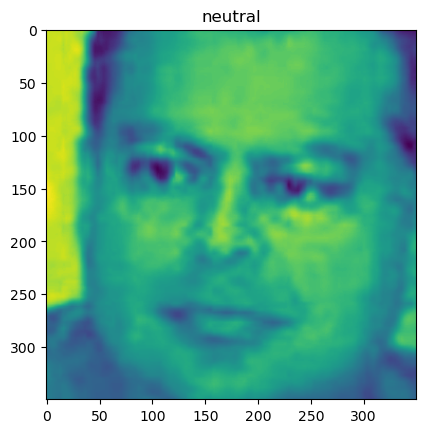

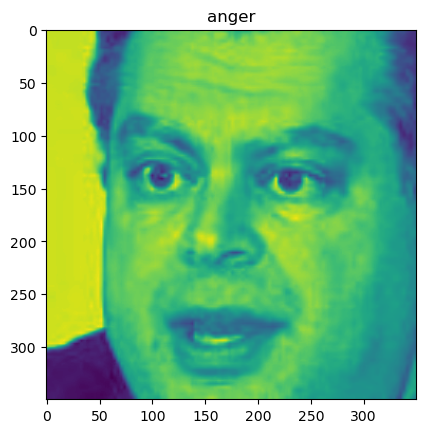

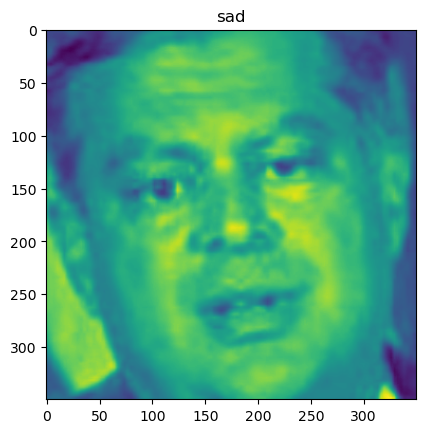

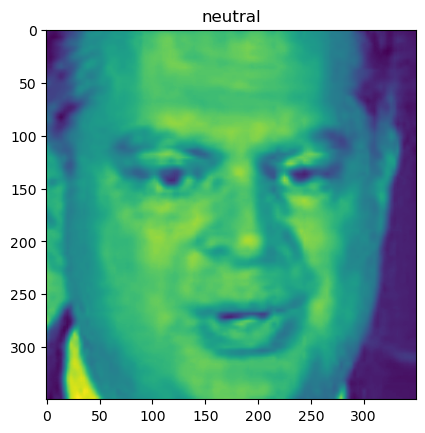

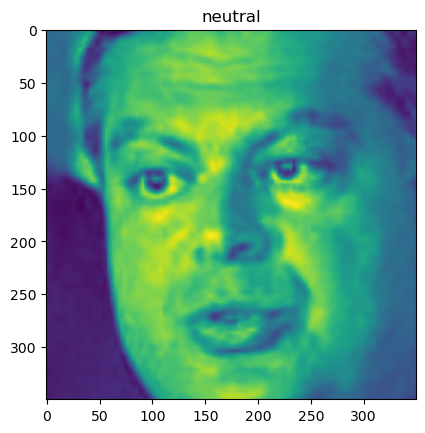

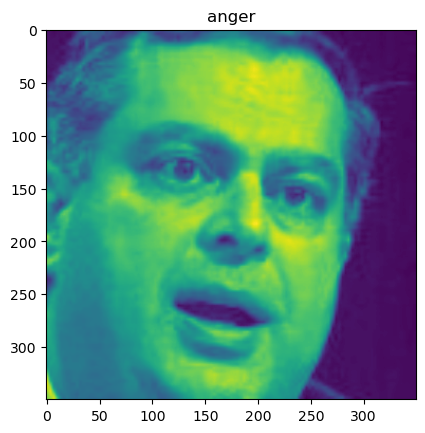

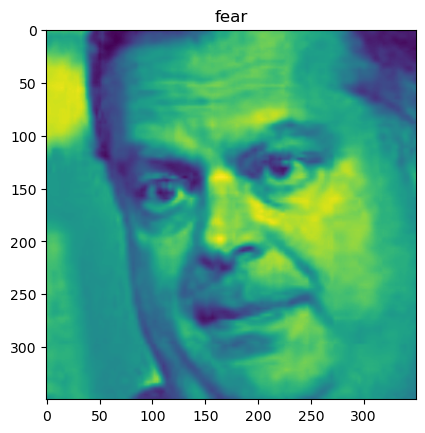

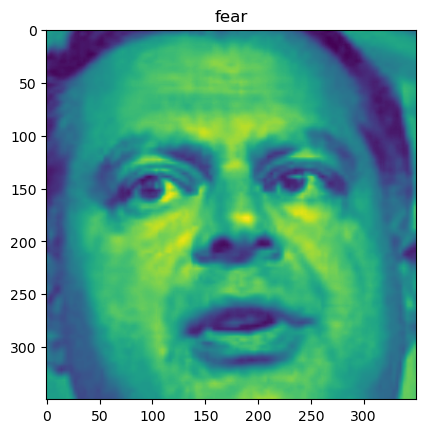

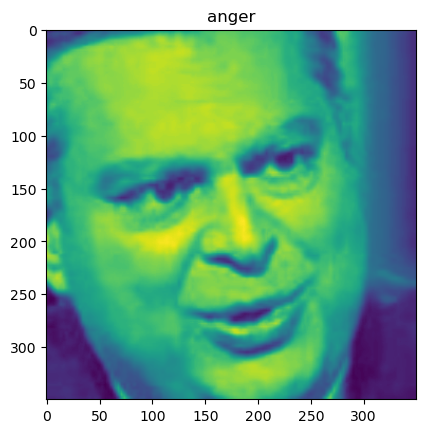

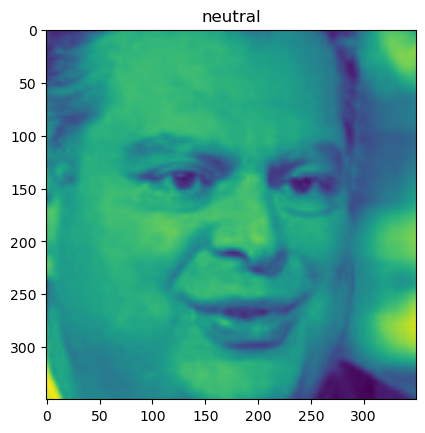

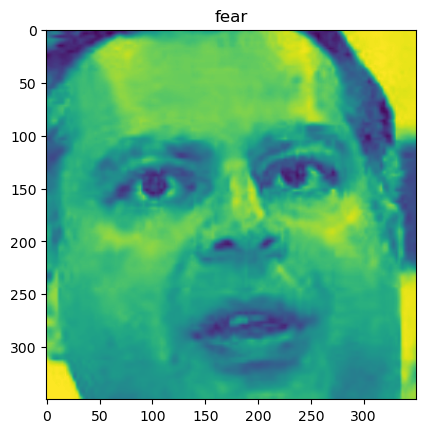

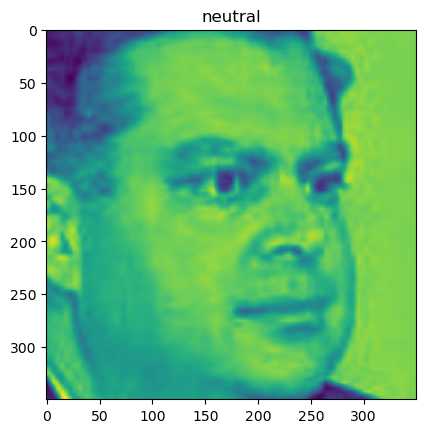

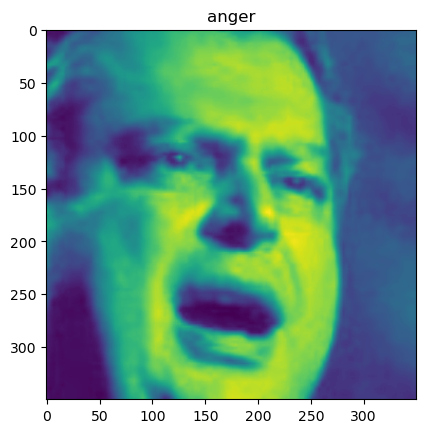

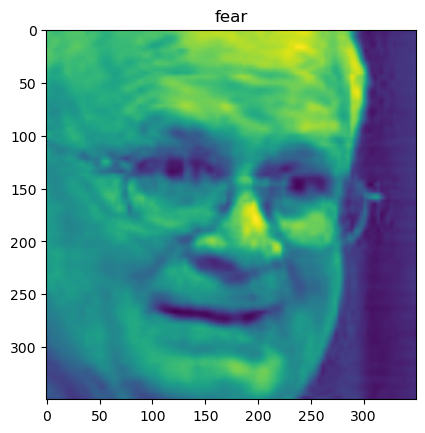

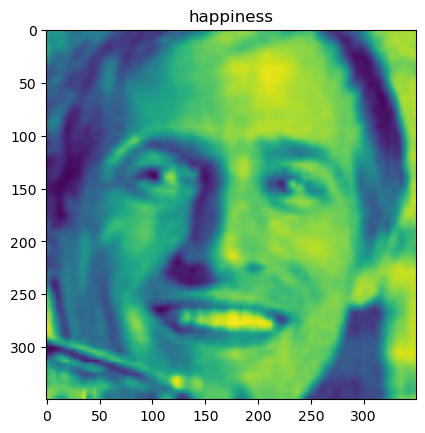

In [21]:
data = pd.read_csv('data/500_picts_satz.csv')


image_paths = data.iloc[:, 1]
labels = data.iloc[:, 2]

folder_path = 'images/'

X = []
y = labels

# Comment below when training
size = 20
count = 0
# Comment above when training

for filename in image_paths:
    # Comment below when training
    if count >= size:
        break
    # Comment above when training
    if filename.endswith(('.png', '.jpg', '.jpeg')):  # Check for common image file extensions
        img_path = os.path.join(folder_path, filename)
        img = cv2.imread(img_path)
        img - cv2.resize(img, (350, 350))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        if img is not None:
            X.append(torch.Tensor(img))
    count += 1
X = torch.stack(X).unsqueeze(1) # convert to pytorch tensor

# Comment below when training
for image, label in zip(X, y):
    plt.imshow(image.numpy()[0])
    plt.title(label)
    plt.show()
# Comment above when training

## CNN Test
### Define a Convolutional Neural Network

In [12]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5) # 1 because its greyscale
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 84 * 84, 120) # shape of image after pooling twice
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 7) # 7 is label count

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()
Xtr, Ytr = X[:10], Y[:10]
Xva, Yva = X[10:20], Y[10:20]

In [13]:
F.softmax(net(Xtr), dim=0)

tensor([[0.0695, 0.0613, 0.0733, 0.1062, 0.0642, 0.2639, 0.0911],
        [0.0508, 0.0790, 0.0852, 0.1333, 0.1399, 0.1059, 0.1376],
        [0.1497, 0.1889, 0.1227, 0.1039, 0.0865, 0.0893, 0.1051],
        [0.0570, 0.0615, 0.0700, 0.0831, 0.0507, 0.1400, 0.1416],
        [0.1459, 0.1026, 0.1476, 0.1036, 0.1242, 0.0467, 0.0772],
        [0.0903, 0.0681, 0.0756, 0.0762, 0.0981, 0.0569, 0.1201],
        [0.0641, 0.0742, 0.0482, 0.1163, 0.1169, 0.0554, 0.0670],
        [0.1041, 0.1127, 0.1005, 0.0668, 0.0886, 0.1138, 0.0873],
        [0.0965, 0.1116, 0.1052, 0.1276, 0.0974, 0.0695, 0.1169],
        [0.1722, 0.1401, 0.1717, 0.0830, 0.1335, 0.0586, 0.0560]],
       grad_fn=<SoftmaxBackward0>)

In [14]:
Xtr.shape

torch.Size([10, 1, 350, 350])

### Define a Loss function and optimizer

In [23]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### Train the network

In [28]:
batch_size = 4
trainloader = torch.utils.data.DataLoader(X, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(y, batch_size=batch_size, shuffle=False, num_workers=2)

for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(X, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

ValueError: not enough values to unpack (expected 2, got 1)